# Demo for Insight Interview

Python Version:

In [1]:
import sys

In [2]:
print(sys.version)

2.7.11 |Continuum Analytics, Inc.| (default, Feb 16 2016, 09:58:36) [MSC v.1500 64 bit (AMD64)]


## Step 0 - Process Data (already done)
* Data comes from a Global Climate Model (GCM) that I set up. 
* There were two simulations run for 300 years each (~600 TB of output).
* Output is in NetCDF format. 
* I reduce the total data to ~8 GB. (i.e., extraction, averaging, slicing, etc.)
* I inspect the data using a variety of visualizations.
* I combine variables and produce new data when needed. (i.e., statistics and models)

**The following uses data I have already reduced for the purpose of this interview.**

## Step 1 - Import modules and functions

In [3]:
#import numpy, scipy, matplotlib and allow to plot in python notebook
%pylab inline
#import basemap, used with matplotlib to plot geophysical data
from mpl_toolkits.basemap import Basemap
#import readsav from scipy to load IDL save binary file format.
from scipy.io.idl import readsav

Populating the interactive namespace from numpy and matplotlib


## Step 2- Read in data

In [4]:
ifile = readsav('C:\\Users\\Lordluen\\Desktop\\prepSeasonal_Monthly_lon_lat_TREFHT.sav') #pre-processed data
print(type(ifile)) #check variable type

<class 'scipy.io.idl.AttrDict'>


In [5]:
ifile.keys() #print out variable keys for dictionary

['syrend',
 'difftrefht',
 'lon',
 'sseasons',
 'ttrefht',
 'strefhtmax',
 'xtrefhtmin',
 'lat',
 'xtrefhtmax',
 'syrstart',
 'strefhtmin']

### Index Descriptors

Variable Name | Description
------------- | -------------------------------------------------
syrend | Array of strings containing model ending years
syrstart | Array of strings containing model starting years
lat | Array of model latitudes for each latitude index
lon | Array of model longitudes for each longitude index
sseasons | Array of strings containing the names of the seasons

### Data Matrices

Variable Name | Description
------------- | ------------------------------------------------------------------------------------
xtrefhtmax | Matrix of mean 2 meter (reference height) temperatures for the max case simulation
strefhtmax | Matrix of std-dev 2 meter temperature for the max case simulation
xtrefhtmin | Matrix of mean 2 meter temperatures for the min case simulation
strefhtmin | Matrix of std-dev 2 meter temperatures for the min case simulation
ttrefht | Matrix Student's T-test t-value results comparing max and min cases
difftrefht | Matrix of difference between max and min cases (xtrefhtmax - xtrefhtmin)

### Pull out data from dictionary variable

In [6]:
#set needed variables to reduce number of 'ifiles' in code.
lat = np.copy(ifile['lat'])
lon = np.copy(ifile['lon'])
sseasons = np.copy(ifile['sseasons'])
syrstart = np.copy(ifile['syrstart'])
syrend = np.copy(ifile['syrend'])
diffx = np.copy(ifile['difftrefht'])
tdiffx = np.copy(ifile['ttrefht'])

#set dimension lengths
nlat = len(lat)
nlon = len(lon)
nyrs = len(syrend)
nseasons = len(sseasons)

#print usefule info about variables
print 'Season names:',sseasons
print 'Starting Years:',syrstart
print 'Ending Years:',syrend

print 'Size of lon:',nlon
print 'Size of lat:',nlat
print 'Number of seasons:',nseasons
print 'Number of year subsets:',nyrs
print 'Dimensions of diffx:',diffx.shape

Season names: ['MAM' 'JJA' 'SON' 'DJF']
Starting Years: ['0010' '0010' '0010' '0010' '0010' '0010' '0100' '0200']
Ending Years: ['0050' '0100' '0150' '0200' '0250' '0300' '0200' '0300']
Size of lon: 144
Size of lat: 96
Number of seasons: 4
Number of year subsets: 8
Dimensions of diffx: (8L, 4L, 96L, 144L)


Note Year Index:  
5 has all years (10-300)  
1 has first century (10-100)  
6 has second century (100-200)  
7 has third century (200-300)  

In [7]:
#going to use 95% confidence levels for stats, so t-value of 1.96
stats = np.copy(tdiffx)
stats[stats < 1.96] = 0  #set values below statistical significance to False
stats[stats >= 1.96] = 1 #set values above statistical significance to True
print 'Dimensions of stats:',stats.shape

Dimensions of stats: (8L, 4L, 96L, 144L)


### Repeat for Bootstrap data

In [8]:
ifile2 = readsav('C:\\Users\\Lordluen\\Desktop\\prepSeasonal_Monthly_lon_lat_TREFHT_Monte.sav') #pre-processed data
ifile2.keys() #print out variable keys for dictionary

['syrend',
 'difftrefht',
 'lon',
 'sseasons',
 'ttrefht',
 'strefhtmax',
 'xtrefhtmin',
 'lat',
 'xtrefhtmax',
 'syrstart',
 'strefhtmin']

In [9]:
#set needed variables to reduce number of 'ifiles' in code.
mlat = np.copy(ifile2['lat']) #m stands for monte!
mlon = np.copy(ifile2['lon'])
msseasons = np.copy(ifile2['sseasons'])
mdiffx = np.copy(ifile2['difftrefht'])

#set dimension lengths
mnlat = len(mlat)
mnlon = len(mlon)
mnseasons = len(msseasons)

#print usefule info about variables
print 'Season names:',msseasons
print 'Size of lon:',mnlon
print 'Size of lat:',mnlat
print 'Number of seasons:',mnseasons
print 'Dimensions of diffx:',mdiffx.shape

Season names: ['MAM' 'JJA' 'SON' 'DJF']
Size of lon: 144
Size of lat: 96
Number of seasons: 4
Dimensions of diffx: (4L, 96L, 144L)


### Calculate t-test on bootstrap results
$$t = \frac{\overline{X}_{1}-\overline{X}_{2}}{\sqrt{\frac{S_{1}^{2}}{n}+\frac{S_{2}^{2}}{n}}}$$

In [10]:
#pull means and std-devs
xmax = np.copy(ifile2['xtrefhtmax']) #mean
xmin = np.copy(ifile2['xtrefhtmin'])
smax = np.copy(ifile2['strefhtmax']) #stdev
smin = np.copy(ifile2['strefhtmin'])
n = 10. #used bootstraps of 10 in this case

#calculate student's t-test on distributions of mean values
mstats = (xmax-xmin)/np.sqrt(((smax**2.)/n)+((smin**2.)/n))

print 'Dimensions of mstats:',mstats.shape

Dimensions of mstats: (4L, 96L, 144L)


In [11]:
#going to use 95% confidence levels for stats, so t-value of 1.96
mstats[mstats < 1.96] = 0  #set values below statistical significance to False
mstats[mstats >= 1.96] = 1 #set values above statistical significance to True

## Step 3 - Visualize Data
### Create Plotting Procedure

In [12]:
def createSubPolarPlot(bmap,fig,pltloc,lat,lon,var,stats,lbound,ubound,title):
    """Creates a subplot of a polar map using Basemap module.
       bmap = The Basemap object to be acted on
       fig = The figure to be plotted
       pltloc = the location of the subplot in the larger figure
       lat = latitude array
       lon = longitude array
       var = data matrix with dimensions equal to length of lon by length of lat
       lbound = lower bound for colorbar
       ubound = upper bound for color bar
       title = the title of the subplot."""
    sp = fig.add_subplot(pltloc) #sp stands for subplot
    bmap.drawcoastlines()
    bmap.drawmapboundary(fill_color='none')
    bmap.drawparallels(np.arange(-80,80,20))
    bmap.drawmeridians(np.arange(30,360,60),labels=[0,0,1,1],weight='bold',fontsize=15)
    sp.set_title(title, y=1.05,weight='bold',fontsize=20)
    lon2,lat2 = np.meshgrid(lon, lat)    #turns lat and lon into matrices
    x,y = bmap(lon2,lat2)                #remaps the lat, lon grid to the map projection
    #generate contour plot (cp)
    cp2 = bmap.contour(x,y,stats,[.95,1,1.05],linewidths=5,colors='lime')
    cp = bmap.pcolor(x,y,var,cmap='bwr') #contours the map without smoothing too much between gridpoints, bwr=blue-white-red
    cp.set_clim(vmin=lbound,vmax=ubound) #sets the range for the color bar
    return cp                            #cp needs to be returned for drawing of axis after the last plot

### Plot the Data

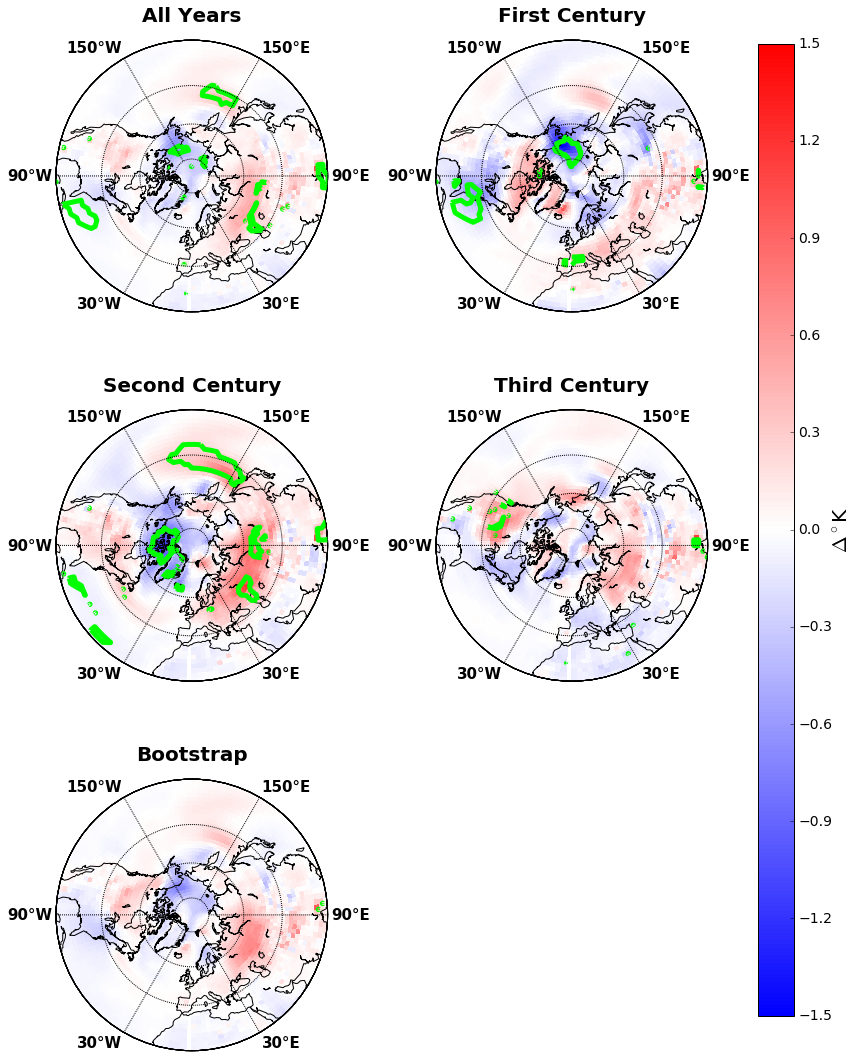

In [13]:
#set up north pole viewing stereographic plot
m = Basemap(resolution='c',projection='npstere', lon_0=0, lat_0=90, boundinglat=20, round=True)
fig = plt.figure(figsize=(10,15))

#plot all years
cp = createSubPolarPlot(m,fig,321,lat,lon,diffx[5,3,:,:],stats[5,3,:,:],-1.5,1.5,'All Years')
#plot first century
cp = createSubPolarPlot(m,fig,322,lat,lon,diffx[1,3,:,:],stats[1,3,:,:],-1.5,1.5,'First Century')
#plot second century
cp = createSubPolarPlot(m,fig,323,lat,lon,diffx[6,3,:,:],stats[6,3,:,:],-1.5,1.5,'Second Century')
#plot third century
cp = createSubPolarPlot(m,fig,324,lat,lon,diffx[7,3,:,:],stats[7,3,:,:],-1.5,1.5,'Third Century')
#plot bootstrap results
cp = createSubPolarPlot(m,fig,325,lat,lon,mdiffx[3,:,:],mstats[3,:,:],-1.5,1.5,'Bootstrap')
#clean-up subplot layout
plt.tight_layout(h_pad = 5,w_pad = 12)#sets padding between subplots

#plot the axis
fig.subplots_adjust(right=0.92) #makes space for error bar
cbar_ax = fig.add_axes([0.99, 0.05, 0.05, 0.9]) #
cbar = fig.colorbar(cp, cbar_ax)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('$\Delta^\circ$K', fontsize=20, labelpad=1)
cbar.set_ticks([-1.5, -1.2, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2, 1.5])

**Conclusions:**  
1. Able to recreate similar results to previous studies when using Student's T-test.
2. Splitting up by century shows signal is not robust, thus Student's T-test is not appropriate.
3. One million member bootstrap of sample size ten shows there is little to no statistical significance at 95% level (p < .05).
4. Auroral EEP has little to no impact on surface climate.
5. My work sets a new standard for use of statistics and model data in climate studies.